In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning

In [2]:
# Loading extracted data to data frames
df_abnom= pd.read_csv('abnom.csv',index_col =0,encoding = "ISO-8859-1")
df_sf= pd.read_csv('side_effects.csv',index_col =0,encoding = "ISO-8859-1")
df_both=pd.read_csv('both.csv',index_col =0,encoding = "ISO-8859-1")
df_others=pd.read_csv('others.csv',index_col =0,encoding = "ISO-8859-1")
# Creating labels 
df_abnom['label']='Congenital Abnormalities'
df_sf['label']='Side Effects'
df_both['label']='Both'
df_others['label']='Other'
# Combining all the data frames
all_data=pd.concat([df_abnom, df_sf,df_both, df_others],axis=0).dropna() 


After deleting rows with empty abstracts and one-sentence abstracts, I got 9,534 abstracts. Unfortunately, the category Both contained only 514 abstracts. That was the only abstacts that PubMed had for the category Both. That means that I am dealing with imbalanced outcome and imbalanced outcome can decrease my accuracy for this specific category. 

In [3]:
# Deleting all the rows that contain one sentence (the articles did not conain full abstracts)
all_data['delete']=all_data['abstract'].map(lambda x: 'delete' if len(x.split('.'))==1 or len(x.split(' '))<=10 else 'do not delete')
df=all_data[all_data['delete']=='do not delete']

print ('\033[1m'+'Data Info:'+'\033[0m')
print (df[['abstract','label']].info())
print ('')
print ('\033[1m'+'Categories:' +'\033[0m')
print (df['label'].value_counts() )

Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9534 entries, 0 to 3699
Data columns (total 2 columns):
abstract    9534 non-null object
label       9534 non-null object
dtypes: object(2)
memory usage: 223.5+ KB
None

Categories:
Congenital Abnormalities    3064
Side Effects                2984
Other                       2972
Both                        514 
Name: label, dtype: int64


I used custom stop list because scientific abstracts have a particular jargon that if included into a bag of words can decrease classifier accuracy. For example, those words are 'aim', 'study', 'report', 'reported', 'studies', 'objective','method','materials','results','backgroud','setting', 'methods','design','designs','conclusion','conclusions','settings', 'objectives','shown','h','th', 'ci', 'p','g','cg','n','show','also','result','may','cases','associated','group','used','data','use', 'however','including','using','p','due','case','well','c','found','remain', 'extend','studied','extensively','experiment','patient', 'mg','kg','follow', 'time', 'week',  'age', 'mean', 'median', 'day', 'showed', 'group', 'total', 'significantly', 'significant', 'respectively'. They are commonly used by scientists to describe results in abstracts. For this reason, they would consider stop words when dealing with scientific abstracts. This is my custom stop list. I've used it in my NLP work and it got me very good results in the past. 

In [4]:
# This is a custom stoplist 

stoplist=["i","one", "two","three","four","five","six","seven","nine", "ten",
          "me", "my", "ok", "okey", "myself", "we", "our", "ours", "ourselves",
          "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", 
          "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they",
          "them", "their", "theirs", "themselves", "what", "which", "who", "whom", 
          "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
          "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing",
          "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", 
          "of", "at", "by", "for", "with", "about", "against", "between", "into", "through",
          "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", 
          "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
          "there", "when", "where","would", "why", "how", "all", "any", "both", "each", 
          "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", 
          "own", "same", "so", "than", "too", "very", "can", "will", "just", 
          "don", "should", "now","i","ill",'im','um','dont','theres','lets',\
          'wont','u','isnt','anything',"way",'bit','lot','someone','anyone','okay',\
          'sure','kind','thats','youve','something','youre','doesnt',\
         'whereas','whats','itll','theyre','youd','little', 'everythings',\
          'things','thing','wouldnt', 'aim', 'study', 'report', 'reported', 'studies',
         'objective','method','materials','results','backgroud','setting',
         'methods','design','designs','conclusion','conclusions','settings',\
         'objectives','shown','h','th', 'ci', 'p','g','cg','n','show','ûø',\
         'also','result','may','cases','associated','group','used','data','use',\
          'however','including','using','p','due','case','well','c','found','remain',
         'extend','studied','extensively','experiment','patient', 'mg','kg','follow', 
          'time', 'week',  'age', 'mean','median', 'day', 'showed', 'group', 'total',
          'significantly', 'significant', 'respectively']

While cleaning text, I got rid of all special characters, digits, capital letters, punctuations, stop words. I also lemmatized my tokens before processing.

In [5]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import itertools, nltk, string,re

# Getting rid of special characters, digits, punctuation, capital letters
df['special_char']=df['abstract'].map(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)).map(lambda x: x.replace('â',' ')).\
map (lambda x: re.sub(r'[0-9]', ' ', x )).map(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).lower())
# Getting rid of stop words and tokenizing text
df['stopped_text']=df['special_char'].map(lambda x: [word for word in nltk.word_tokenize(x) if word if word not in set(stoplist)])
wordnet_lemmatizer = WordNetLemmatizer()
# Lemmatizing tokens
df['lemma_text']=df['stopped_text'].map(lambda x:  [wordnet_lemmatizer.lemmatize(word) if len(word)>= 5 else word for word in x])
# Extracting text from lists
df['text'] = df['lemma_text'].map(lambda x: ", ".join(map(str, x)))

### Building Model

I tried several approaches to reach higher accuracy scores. First, I vectorized my text using tf-idf weights and count. Convert text into tf-idf vectors, count vectors, and topics using LDA model. Then I tried to combine features from different vectors. The best accuracy was obtained by combining tf-idf features with 20 topic features. Unfortunately, increasing number of topics in LDA model would yield me lower accuracy while training my classifiers so I only extracted 20 topics. Note: In this case, I do not specifically care about extracting specific topics, however,  I care about feature extraction using LDA model that could get me the best classifier's result. Specifically, including 20 topic vectors helped me to increase recall of the imbalanced category Both (from 59% to 64%).

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Vectorizong data using tfidf vectorizer and count vectorizer 
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf = tfidf_vect.fit_transform(df.text).toarray()
count_vect = CountVectorizer(analyzer='word')
countvec = count_vect.fit_transform(df.text).toarray()

In [8]:
from sklearn import decomposition
from time import time

# Getting topics from the data using LDA model
start = time()
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
topics = lda_model.fit_transform(countvec)
print('Time used {:.2f}s'.format(time()-start))

Time used 501.37s


In [9]:
print ('TFIDF shape: ',tfidf.shape)
print ('Topics shape: ',topics.shape)

TFIDF shape:  (9534, 31765)
Topics shape:  (9534, 20)


In [10]:
# Combining topics and df-idf vectors
X=np.concatenate((topics,tfidf),axis=1)
y = df.label
print ('X shape: ',X.shape)

X shape:  (9534, 31785)


In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Training data using Stratified K-fold 

X_train, X_test, y_train, y_test = train_test_split(X,\
                                                    y,train_size=0.7,random_state=1,stratify=y)

rf = RandomForestClassifier(random_state=0)
mb = MultinomialNB()
lr = LogisticRegression(random_state=0)
svc = LinearSVC(random_state=0)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=78)
def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

print ('\033[1m'+'Traning Accuracy' +'\033[0m')
print (' ')
score(rf,"Random Forest")
score(mb, "NB")
score(lr, "Logistic Regression")
score(svc, "Linear SVC")

Traning Accuracy
 
Random Forest Score:	0.793 ± 0.01
NB Score:	0.79 ± 0.012
Logistic Regression Score:	0.833 ± 0.012
Linear SVC Score:	0.871 ± 0.007


I picked Linear SVC  as my algorithm of choice since it gave me the best accuracy score.

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fitting training data into the algorithm of my choice
svc.fit(X_train, y_train)
# Getting predicted values
y_pred = svc.predict(X_test)
# Estimating test accuracy
test_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
# Estimating confusion matrix
matrix_clf = np.array(confusion_matrix(y_test,y_pred))
# Putting confusion matrix into a data frame
confusion_clf = pd.DataFrame(matrix_clf,index=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'], columns=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'])

print (('\033[1m'+'Test Accuracy Linear SVC: %.2f%%' +'\033[0m')% (100 * test_acc))
print ('\033[1m'+'                              Classification Report' +'\033[0m')
print ('')
print (classification_report(y_test, y_pred))

Test Accuracy Linear SVC: 87.84%
                              Classification Report

                          precision    recall  f1-score   support

                    Both       0.92      0.64      0.76       154
Congenital Abnormalities       0.89      0.91      0.90       920
                   Other       0.84      0.86      0.85       892
            Side Effects       0.90      0.90      0.90       895

                accuracy                           0.88      2861
               macro avg       0.89      0.83      0.85      2861
            weighted avg       0.88      0.88      0.88      2861



Overall, I got a pretty decent result. However, as I expected recall for imbalanced class Other was below average. To combat imbalanced classes, I used a synthetic minority oversampling technique. Using SMOTE for text classification have been done in the past and it has been shown to increase precision and recall accuracies (https://pdfs.semanticscholar.org/2cba/d4a57d962fa9c78f0ac46bc52a171ab2a5ed.pdf). 

After trying several oversampling techniques, SMOTE regular got me the best results. In addition, this method had the fastest training time. The method generates minority class samples so that they are positioned randomly between a minority sample and its nearest neighbor. SMOTE regular will take a minority class sample from the feature space, and randomly choose a neighbor from K-nearest neighbors.  This method helps prevent over-fitting as it populates empty data space instead of simply replicating existing samples. 

I also played with undersampling techniques, but they did not help me to get better results so I ended up sticking with the synthetic oversampling. 


In [13]:
from imblearn.over_sampling import SMOTE
from time import time


start = time()
# Creating syntetic samples by applying the SMOTE regular technique
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_sample(X, y)

print('Time used {:.2f}s'.format(time()-start))

Time used 824.19s


After creating synthetic samples, I trained my algorithms again. Again, Support Vector Machine algorithm got me the best accuracy results. 

In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Training data using Stratified K-fold

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled,\
                                                     y_resampled,train_size=0.7,random_state=1,stratify=y_resampled)

rf_smote = RandomForestClassifier(random_state=0)
mb_smote = MultinomialNB()
lr_smote = LogisticRegression(random_state=0)
svc_smote = LinearSVC(random_state=0)


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=78)
def score(model, name):
    s = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

print ('\033[1m'+'Traning Accuracy SMOTE' +'\033[0m')
print (' ')
score(rf_smote,"Random Forest SMOTE")
score(mb_smote, "NB SMOTE")
score(lr_smote, "Logistic Regression SMOTE")
score(svc_smote, "Linear SVC SMOTE")

Traning Accuracy SMOTE
 
Random Forest SMOTE Score:	0.833 ± 0.003
NB SMOTE Score:	0.828 ± 0.01
Logistic Regression SMOTE Score:	0.865 ± 0.007
Linear SVC SMOTE Score:	0.905 ± 0.005


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Fitting training data into the algorithm of my choice
svc_smote.fit(X_train_smote, y_train_smote)
# Getting predicted values
y_pred_smote = svc_smote.predict(X_test)
# Estimating test accuracy
test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_smote)
# Estimating confusion matrix
matrix_clf_smote = np.array(confusion_matrix(y_test,y_pred_smote))
# Putting confusion matrix into a data frame
confusion_clf_smote = pd.DataFrame(matrix_clf_smote,index=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'], columns=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'])

print (('\033[1m'+'Test Accuracy Linear SVC SMOTE: %.2f%%' +'\033[0m')% (100 * test_acc))
print ('')
print ('\033[1m'+'                              Classification Report SMOTE' +'\033[0m')
print (classification_report(y_test, y_pred_smote))

Test Accuracy Linear SVC SMOTE: 96.30%

                              Classification Report SMOTE
                          precision    recall  f1-score   support

                    Both       0.94      0.99      0.97       154
Congenital Abnormalities       0.96      0.97      0.96       920
                   Other       0.95      0.95      0.95       892
            Side Effects       0.99      0.96      0.97       895

                accuracy                           0.96      2861
               macro avg       0.96      0.97      0.96      2861
            weighted avg       0.96      0.96      0.96      2861



I got higher test accuracy score than my training scores (96% vs 90%). I tried various oversampling techniques and undersampling techniques, feature selection, different splits between train and validation sets. All of those tries resulted in better test accuracy scores (4-6 points higher) after testing on actual cases. 

I think that since I trained my algorithms on a synthetic sample but tested on an imbalance test set (the way it should be done), it is possible that the fact that my algorithm is giving me better results on actual data has to do with the issue of imbalanced classes rather than with underfitting. There is a way to check that. If the problem has to do with underfitting then testing on synthetic sample would give also give me much higher accuracy score. You can see below that this is not the case.I get accuracy of 91% while testing synthetic samples which is compatible with my training accuracy. However, with synthetic samples, algorithm perform slightly worse at the categories Other and Side Effects. When used on actual data, it does much better on the same categories. At worse, that is how we can expect the algorithm to perform. 

There might be other ways to handle this issue. One way to handle this problem is to do tune model parameters. Due to time shortage, I was able to tune model’s parameters, but this can help with this ‘underfitting’ problem as well and, in general, would improve the model’s performance. 

PS: In some cases, difference of 6 points might not be even consider underfitting. I would have more concerns if that difference was over 10 points. 

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Fitting training data into the algorithm of my choice
svc_smote.fit(X_train_smote, y_train_smote)
# Getting predicted values
y_pred_smote = svc_smote.predict(X_test_smote)
# Estimating test accuracy
test_acc = accuracy_score(y_true=y_test_smote, y_pred=y_pred_smote)
# Estimating confusion matrix
matrix_clf_smote_s = np.array(confusion_matrix(y_test_smote,y_pred_smote))
# Putting confusion matrix into a data frame
confusion_clf_smote_s = pd.DataFrame(matrix_clf_smote_s,index=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'], columns=['Both','Congenital\nAbnormalities',\
                'Other','Side Effects'])

print (('\033[1m'+'Test Accuracy Linear SVC SMOTE - Synthetic Sample: %.2f%%' +'\033[0m')% (100 * test_acc))
print ('')
print ('\033[1m'+'                              Classification Report SMOTE' +'\033[0m')
print (classification_report(y_test_smote, y_pred_smote))

Test Accuracy Linear SVC SMOTE - Synthetic Sample: 91.08%

                              Classification Report SMOTE
                          precision    recall  f1-score   support

                    Both       0.97      1.00      0.98       919
Congenital Abnormalities       0.90      0.88      0.89       920
                   Other       0.84      0.87      0.86       919
            Side Effects       0.94      0.89      0.92       919

                accuracy                           0.91      3677
               macro avg       0.91      0.91      0.91      3677
            weighted avg       0.91      0.91      0.91      3677



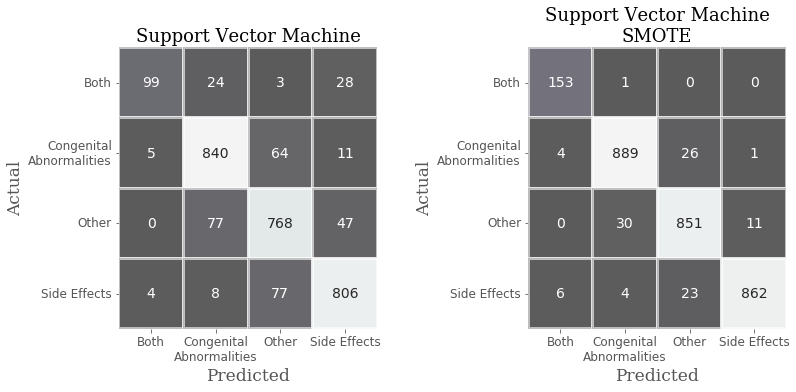

In [17]:
plt.style.use('ggplot')

fig, axes = plt.subplots(ncols=2, figsize=(10,4.5))
plt.tight_layout(w_pad=12)
confusion_matrix=[confusion_clf,confusion_clf_smote]
titles=['Support Vector Machine','Support Vector Machine\nSMOTE']
for ax,matrix, title in zip(axes.flat,confusion_matrix, titles):
    sns.heatmap(matrix, annot=True, annot_kws={"size": 14},cmap="bone",fmt='g',\
            cbar=False,linewidths=2,ax=ax, alpha=.6)
    ax.set_ylabel('Actual', fontsize=17,family='serif')
    ax.set_xlabel('Predicted', fontsize=17,family='serif')
    ax.set_title(title, fontsize=18, y=1.05,family='serif')
    ax.set_ylim(len(matrix_clf), 0)
    ax.set_yticklabels(('Both','Congenital\nAbnormalities',\
                'Other','Side Effects'),rotation=0, fontsize=12, va="center")
    ax.set_xticklabels(('Both','Congenital\nAbnormalities',\
                'Other','Side Effects'), rotation=0, fontsize=12)

We can see that algorithm mostly misclassifies between categories Other, Side Effects, and Congenital Abnormalities. For this reason, I think that cleaning category Other (offered above) can help increase the accuracy of the classifier. It is possible that some abstracts from category Other also contain topics on Congenital Abnormalities and/or Drug-Related Side Effects. To eliminate abstracts from category Other that contain words relevant to ‘Congenital Abnormalities’ or ‘Drug-Related Side Effects’ might help to improve classification pattern for these categories. It is something that is worth trying given more time. It might also help with the problem of 'underfitting' mentioned above. 

In general, however, the algorithm perform much better after being trained on the synthetically created sample than on the imbalanced sample. It is a good result. 

### Conclusion

I have tried many more things to improve accuracy of my algorithm. I’ve tried to get rid of low-frequency words using the code below and preform tf-idf feature selection using chi-squared statistics. The chi-squared statistic measures the lack of independence between a feature and class. It did not help me to improve classifier’s accuracy. It would be more useful in the cases when my matrix is so huge that it cannot be trained without dimensionality reduction. The codes I used are in the Appendix.

I did not try PCA because it does not usually do well on sparse data. 

What I would love to do given more time:

1. I would love to try to create features using Doc2Vec approach and train my model. But I would need to find pre-trained algorithm using abstracts from PubMed or relevant data or train my own Doc2Vec model using PubMed abstracts. 

2. I would definitely tune my model's parameters. I think it would help me a lot to improve stability and performance of my algorithm. 

3. Finally, I would definitely clean category Other as it seems to me that I could accidently fetch some abstracts related to the categories Congenital Abnormalities and Side Effects given the results of the confusion matrix.


### Appendix

In [ ]:
# Code to clean low frequncy words

flat_list = [item for sublist in df['lemma_text'].tolist() for item in sublist]

frequency = {}
for word in flat_list:
    count = frequency.get(word,0)
    frequency[word] = count + 1   
df_=pd.Series(frequency).to_frame().reset_index()
result = df_.sort_values(0, ascending=False)
low_freq_words=result[result[0]<=30]
low_freq_list=set(low_freq_words['index'].tolist())
df['clean_freq']=df['lemma_text'].map(lambda x: [word for word in x if word not in low_freq_list])
df['text'] = df['clean_freq'].map(lambda x: ", ".join(map(str, x)))

In [ ]:
# Code to do feature selection using chi-squared statistic 

x_train, x_validation, y_train, y_validation = train_test_split(df.text,\
                                                    y,train_size=0.7,random_state=1,stratify=y)


from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
plt.style.use(['ggplot'])
tvec = TfidfVectorizer(max_features=30000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(10,7))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=.9, color='slategrey')
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8, color='black')
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

In [ ]:
# Feature Selection using Chi2
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(10000,30000,5000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LinearSVC(random_state=0)
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print ("chi2 feature selection evaluation calculated for {} features".format(n), round(score,3))